In [ ]:
#Packages
using Pkg
Pkg.add("CoordinateTransformations")
Pkg.add("StaticArrays")

# McBride Validation

We use a 2D model (x,z) with $$c(z)=332+0.6z$$. Comparison with Figure 3.9 of McBride 2017. The source is located at (0,100) and the receivers approximately at (58,280)m, (150,220)m and (86,117)m

In [1]:
using DifferentialEquations
T=20.
# ODE 
function q!(dq, q, p, z)
    q_aux=sqrt(q[1]^2 + q[2]^2 )
    dq[1]=0
    dq[2] = -q_aux*q[2]*0.6
end
c_air=332+100*0.6
# We define the initial conditions and parameters 

T_z_0m = T

# We define the range of z values. We must be careful when optimizing,
# because if any optimized value (z coordinate) is outside of zspan we cannot evaluate it.
zspan = (100., 500.)

# We define the parameters 
p = [T_z_0m]

function Hamiltonian_l(qx::Float64,qz_z_linear, SegmentsCoords::Array{Float64, 2})
    # We calculate the travel time between each segment taking the average of the q between each segment
    #(trapezoid rule approximation).
    taus=zeros(length(SegmentsCoords[:,1])-1)
    for i in 1:(length(SegmentsCoords[:,1])-1)
        qz_m=(qz_z_linear(SegmentsCoords[i,2])+qz_z_linear(SegmentsCoords[i+1,2]))/2
        q_m=sqrt(qx^2+qz_m^2)
        aux1=(SegmentsCoords[i+1,1]-SegmentsCoords[i,1])
        aux2=(SegmentsCoords[i+1,2]-SegmentsCoords[i,2])
        taus[i] = q_m*sqrt(aux1^2+aux2^2)
    end
   # We add up the travel time of each segment to get the total.
    total_travel_time = sum(taus)
    return total_travel_time
end

Hamiltonian_l (generic function with 1 method)

In [2]:
#Function to obtain slowness and initial polar angle (straight line)
using LinearAlgebra
function Slowness_Spherical_2D(Point1::Array{Float64, 1}, Point2::Array{Float64, 1}, c_source)
    q0=1/c_source
    x1,z1=Point2-Point1
    r=norm(Point2-Point1)
    theta=rad2deg(acos(z1/r)) 
    qx=abs(q0*sind(theta))
    qz=abs(q0*cosd(theta))
    return qx,qz,theta
end
Slowness_Spherical_2D([0.,100.],[60.,292.74], 332)
    
    

(0.0008952745668717472, 0.0028759203336476765, 17.2913756044773)

In [3]:
using Interpolations
using Optim
using Statistics
@time begin  
Source=[0.,100.]
Receiver=[60.,292.74]
# With the source and the receiver we give an initial angle.

q_x,q_z,theta_i=Slowness_Spherical_2D(Source,Receiver, c_air)
println("Polar angle 1 segment: ", theta_i)
u0 = [q_x, q_z]
prob = ODEProblem(q!, u0, zspan, p)
sol = solve(prob, RK4(),dt=1e-5,saveat=Source[2]:1:500.)

# We save the values of vec(q)
qx_vals=zeros(length(sol.u))
qz_vals=zeros(length(sol.u))
for i in 1:length(sol.u)
    qx_vals[i]=sol.u[i][1]
    qz_vals[i]=sol.u[i][2]
end
###### 
qx=sum(qx_vals)/length(qx_vals)
######
z_values_linear = collect(range(Source[2], stop=500., length=length(qz_vals)))
qz_z_linear=LinearInterpolation(z_values_linear, qz_vals)

# We optimize the coordinates of the junctions between segments
function objective(SegmentsCoords)
    #  # First we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords
    FullSegmentsCoords = vcat(reshape(Source, 1, :), SegmentsCoords, reshape(Receiver, 1, :))
    last_angle_traveltime = Hamiltonian_l(qx, qz_z_linear, FullSegmentsCoords)
    # We calculate the distances between consecutive segments
    segment_distances = diff(FullSegmentsCoords, dims=1)
    # We calculate the standard deviation of the distances , normalized
    distance_std_normalized = Statistics.std(segment_distances)/(Receiver[2]-Source[2])
    # We add a penalty to the objective function based on the standard deviation of the distances
    return last_angle_traveltime 
end

n=8 # Number of iterations
# We define a matrix of matrices Plot_Coords the size of the loop or larger to then plot the distance of the points to a line
Plot_Coords = Matrix{Matrix{Float64}}(undef, n, 1)
# We iterate the initial condition
initial_SegmentsCoords = zeros(1, 2); #c.i.
    
for i in 1:n
    if i == 1
        initial_SegmentsCoords[1, :] = Source + (Receiver - Source) / 2
    end
    lower_bounds = fill(-100., size(initial_SegmentsCoords))
    upper_bounds = fill(600., size(initial_SegmentsCoords))
    inner_optimizer = LBFGS()
    optimizer_with_constraints = Fminbox(inner_optimizer)
    result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)
    Optimal_SegmentsCoords = result.minimizer;
    Full_Optimal_SegmentsCoords= vcat(reshape(Source, 1, :), Optimal_SegmentsCoords, reshape(Receiver, 1, :))
    # We store the coordinates of the optimization including the source and the receiver for later plotting
    Plot_Coords[i]=Full_Optimal_SegmentsCoords
    # We evaluate the traveltime for the different number of segments proposed
    total_time = Hamiltonian_l(qx, qz_z_linear, Full_Optimal_SegmentsCoords)
    println("No. segments: ", 2^(i-1), ". Traveltime:", total_time, " s")
    println("Iterations performed: ", result.iterations, ". Function evaluations: ", result.f_calls)
        

    copy_Optimal_SegmentsCoords = zeros(2 * size(Optimal_SegmentsCoords, 1) + 1, 2)
    # We calculate copy_optimal_SegmentsCoords 
    for j in 1:2 * size(Optimal_SegmentsCoords, 1) + 1
        if j==1
            copy_Optimal_SegmentsCoords[j,:]=(Source+Optimal_SegmentsCoords[1,:])/2
        elseif j==2*size(Optimal_SegmentsCoords,1)+1
            copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[end,:]+Receiver)/2
        else
            if iseven(j)
                copy_Optimal_SegmentsCoords[j,:]=Optimal_SegmentsCoords[Int(j/2),:]
            else
                copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[Int((j-1)/2),:]+Optimal_SegmentsCoords[Int((j+1)/2),:])/2
            end
        end
    end
     # Here we iterate the initial condition
    initial_SegmentsCoords = copy(copy_Optimal_SegmentsCoords)
        
    q_x,q_z,theta_i=Slowness_Spherical_2D(Source,Optimal_SegmentsCoords[1,:], c_air)
    println("Polar angle ", 2^i, "segments: ", theta_i)
    u0 = [q_x, q_z]
    prob = ODEProblem(q!, u0, zspan, p)
    sol = solve(prob, RK4(),dt=1e-5,saveat=Source[2]:1:500.)

    #We save the values of vec(q)
    qx_vals=zeros(length(sol.u))
    qz_vals=zeros(length(sol.u))
    for i in 1:length(sol.u)
        qx_vals[i]=sol.u[i][1]
        qz_vals[i]=sol.u[i][2]
    end
    ###### 
    qx=sum(qx_vals)/length(qx_vals)
    ######
    z_values_linear = collect(range(Source[2], stop=500., length=length(qz_vals)))
    qz_z_linear=LinearInterpolation(z_values_linear, qz_vals)
end
traveltime=Hamiltonian_l(qx, qz_z_linear, Plot_Coords[n])
println("No. segments: ", 2^n, ". Traveltime:", traveltime, " s")
P1_ImPropia=deepcopy(Plot_Coords[n]);
""
end

Ángulo 1 segmento: 17.2913756044773
Num segments: 1. Traveltime:0.4579307921598585 s
Iteraciones realizadas: 2. Evaluaciones de la función: 68
Polar angle 2segments: 16.186963926984895
Num segments: 2. Traveltime:0.4564361826379604 s
Iteraciones realizadas: 2. Evaluaciones de la función: 331
Polar angle 4segments: 15.66888437151421
Num segments: 4. Traveltime:0.45592104489951535 s
Iteraciones realizadas: 2. Evaluaciones de la función: 1094
Polar angle 8segments: 15.417558863055273
Num segments: 8. Traveltime:0.45572251126734836 s
Iteraciones realizadas: 2. Evaluaciones de la función: 3516
Polar angle 16segments: 15.291290116899114
Num segments: 16. Traveltime:0.4556367369061331 s
Iteraciones realizadas: 2. Evaluaciones de la función: 3241
Polar angle 32segments: 15.228652624142322
Num segments: 32. Traveltime:0.45559758157235836 s
Iteraciones realizadas: 4. Evaluaciones de la función: 11813
Polar angle 64segments: 15.199036551513625
Num segments: 64. Traveltime:0.4555798993325693 s
Ite

""

In [4]:
using Interpolations
using Optim
using Statistics
@time begin  
Source=[0.,100.]
Receiver=[150.,221.49]
# With the source and the receiver we give an initial angle.

q_x,q_z,theta_i=Slowness_Spherical_2D(Source,Receiver, c_air)
println("Polar angle 1 segment: ", theta_i)
u0 = [q_x, q_z]
prob = ODEProblem(q!, u0, zspan, p)
sol = solve(prob, RK4(),dt=1e-5,saveat=Source[2]:1:500.)

# We save the values of vec(q)
qx_vals=zeros(length(sol.u))
qz_vals=zeros(length(sol.u))
for i in 1:length(sol.u)
    qx_vals[i]=sol.u[i][1]
    qz_vals[i]=sol.u[i][2]
end
###### 
qx=sum(qx_vals)/length(qx_vals)
######
z_values_linear = collect(range(Source[2], stop=500., length=length(qz_vals)))
qz_z_linear=LinearInterpolation(z_values_linear, qz_vals)

# We optimize the coordinates of the junctions between segments
function objective(SegmentsCoords)
    #  # First we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords
    FullSegmentsCoords = vcat(reshape(Source, 1, :), SegmentsCoords, reshape(Receiver, 1, :))
    last_angle_traveltime = Hamiltonian_l(qx, qz_z_linear, FullSegmentsCoords)
    # We calculate the distances between consecutive segments
    segment_distances = diff(FullSegmentsCoords, dims=1)
    # We calculate the standard deviation of the distances , normalized
    distance_std_normalized = Statistics.std(segment_distances)/(Receiver[2]-Source[2])
    # We add a penalty to the objective function based on the standard deviation of the distances
    return last_angle_traveltime 
end

n=8 # Number of iterations
# We define a matrix of matrices Plot_Coords the size of the loop or larger to then plot the distance of the points to a line
Plot_Coords = Matrix{Matrix{Float64}}(undef, n, 1)
# We iterate the initial condition
initial_SegmentsCoords = zeros(1, 2); #c.i.
    
for i in 1:n
    if i == 1
        initial_SegmentsCoords[1, :] = Source + (Receiver - Source) / 2
    end
    lower_bounds = fill(-100., size(initial_SegmentsCoords))
    upper_bounds = fill(600., size(initial_SegmentsCoords))
    inner_optimizer = LBFGS()
    optimizer_with_constraints = Fminbox(inner_optimizer)
    result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)
    Optimal_SegmentsCoords = result.minimizer;
    Full_Optimal_SegmentsCoords= vcat(reshape(Source, 1, :), Optimal_SegmentsCoords, reshape(Receiver, 1, :))
    # We store the coordinates of the optimization including the source and the receiver for later plotting
    Plot_Coords[i]=Full_Optimal_SegmentsCoords
    # We evaluate the traveltime for the different number of segments proposed
    total_time = Hamiltonian_l(qx, qz_z_linear, Full_Optimal_SegmentsCoords)
    println("No. segments: ", 2^(i-1), ". Traveltime:", total_time, " s")
    println("Iterations performed: ", result.iterations, ". Function evaluations: ", result.f_calls)
        

    copy_Optimal_SegmentsCoords = zeros(2 * size(Optimal_SegmentsCoords, 1) + 1, 2)
    # We calculate copy_optimal_SegmentsCoords 
    for j in 1:2 * size(Optimal_SegmentsCoords, 1) + 1
        if j==1
            copy_Optimal_SegmentsCoords[j,:]=(Source+Optimal_SegmentsCoords[1,:])/2
        elseif j==2*size(Optimal_SegmentsCoords,1)+1
            copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[end,:]+Receiver)/2
        else
            if iseven(j)
                copy_Optimal_SegmentsCoords[j,:]=Optimal_SegmentsCoords[Int(j/2),:]
            else
                copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[Int((j-1)/2),:]+Optimal_SegmentsCoords[Int((j+1)/2),:])/2
            end
        end
    end
     # Here we iterate the initial condition
    initial_SegmentsCoords = copy(copy_Optimal_SegmentsCoords)
        
    q_x,q_z,theta_i=Slowness_Spherical_2D(Source,Optimal_SegmentsCoords[1,:], c_air)
    println("Polar angle ", 2^i, "segments: ", theta_i)
    u0 = [q_x, q_z]
    prob = ODEProblem(q!, u0, zspan, p)
    sol = solve(prob, RK4(),dt=1e-5,saveat=Source[2]:1:500.)

    #We save the values of vec(q)
    qx_vals=zeros(length(sol.u))
    qz_vals=zeros(length(sol.u))
    for i in 1:length(sol.u)
        qx_vals[i]=sol.u[i][1]
        qz_vals[i]=sol.u[i][2]
    end
    ###### 
    qx=sum(qx_vals)/length(qx_vals)
    ######
    z_values_linear = collect(range(Source[2], stop=500., length=length(qz_vals)))
    qz_z_linear=LinearInterpolation(z_values_linear, qz_vals)
end
traveltime=Hamiltonian_l(qx, qz_z_linear, Plot_Coords[n])
println("No. segments: ", 2^n, ". Traveltime:", traveltime, " s")
P2_ImPropia=deepcopy(Plot_Coords[n]);
""
end

Polar angle 1 segment: 50.9948339771856
No. segments: 1. Traveltime:0.4763302707837451 s
Iterations performed: 2. Function evaluations: 86
Polar angle 2segments: 49.80986593658793
No. segments: 2. Traveltime:0.47538155200668897 s
Iterations performed: 2. Function evaluations: 236
Polar angle 4segments: 49.13685626130963
No. segments: 4. Traveltime:0.4748711912280873 s
Iterations performed: 2. Function evaluations: 2879
Polar angle 8segments: 48.78896077994655
No. segments: 8. Traveltime:0.4746141350296325 s
Iterations performed: 2. Function evaluations: 6592
Polar angle 16segments: 48.62627312266357
No. segments: 16. Traveltime:0.4744953385340171 s
Iterations performed: 5. Function evaluations: 16758
Polar angle 32segments: 48.52739199150674
No. segments: 32. Traveltime:0.47442378894023046 s
Iterations performed: 4. Function evaluations: 10405
Polar angle 64segments: 48.464512919753446
No. segments: 64. Traveltime:0.4743784759429785 s
Iterations performed: 2. Function evaluations: 4566

""

In [5]:
using Interpolations
using Optim
using Statistics
@time begin  
Source=[0.,100.]
Receiver=[86,117.16]
# With the source and the receiver we give an initial angle.

q_x,q_z,theta_i=Slowness_Spherical_2D(Source,Receiver, c_air)
println("Polar angle 1 segment: ", theta_i)
u0 = [q_x, q_z]
prob = ODEProblem(q!, u0, zspan, p)
sol = solve(prob, RK4(),dt=1e-5,saveat=Source[2]:1:500.)

# We save the values of vec(q)
qx_vals=zeros(length(sol.u))
qz_vals=zeros(length(sol.u))
for i in 1:length(sol.u)
    qx_vals[i]=sol.u[i][1]
    qz_vals[i]=sol.u[i][2]
end
###### 
qx=sum(qx_vals)/length(qx_vals)
######
z_values_linear = collect(range(Source[2], stop=500., length=length(qz_vals)))
qz_z_linear=LinearInterpolation(z_values_linear, qz_vals)

# We optimize the coordinates of the junctions between segments
function objective(SegmentsCoords)
    #  # First we make sure that SourcePoint and ReceiverPoint are not optimized but are included in SegmentsCoords
    FullSegmentsCoords = vcat(reshape(Source, 1, :), SegmentsCoords, reshape(Receiver, 1, :))
    last_angle_traveltime = Hamiltonian_l(qx, qz_z_linear, FullSegmentsCoords)
    # We calculate the distances between consecutive segments
    segment_distances = diff(FullSegmentsCoords, dims=1)
    # We calculate the standard deviation of the distances , normalized
    distance_std_normalized = Statistics.std(segment_distances)/(Receiver[2]-Source[2])
    # We add a penalty to the objective function based on the standard deviation of the distances
    return last_angle_traveltime 
end

n=8 # Number of iterations
# We define a matrix of matrices Plot_Coords the size of the loop or larger to then plot the distance of the points to a line
Plot_Coords = Matrix{Matrix{Float64}}(undef, n, 1)
# We iterate the initial condition
initial_SegmentsCoords = zeros(1, 2); #c.i.
    
for i in 1:n
    if i == 1
        initial_SegmentsCoords[1, :] = Source + (Receiver - Source) / 2
    end
    lower_bounds = fill(-100., size(initial_SegmentsCoords))
    upper_bounds = fill(600., size(initial_SegmentsCoords))
    inner_optimizer = LBFGS()
    optimizer_with_constraints = Fminbox(inner_optimizer)
    result = optimize(objective, lower_bounds, upper_bounds, initial_SegmentsCoords, optimizer_with_constraints)
    Optimal_SegmentsCoords = result.minimizer;
    Full_Optimal_SegmentsCoords= vcat(reshape(Source, 1, :), Optimal_SegmentsCoords, reshape(Receiver, 1, :))
    # We store the coordinates of the optimization including the source and the receiver for later plotting
    Plot_Coords[i]=Full_Optimal_SegmentsCoords
    # We evaluate the traveltime for the different number of segments proposed
    total_time = Hamiltonian_l(qx, qz_z_linear, Full_Optimal_SegmentsCoords)
    println("No. segments: ", 2^(i-1), ". Traveltime:", total_time, " s")
    println("Iterations performed: ", result.iterations, ". Function evaluations: ", result.f_calls)
        

    copy_Optimal_SegmentsCoords = zeros(2 * size(Optimal_SegmentsCoords, 1) + 1, 2)
    # We calculate copy_optimal_SegmentsCoords 
    for j in 1:2 * size(Optimal_SegmentsCoords, 1) + 1
        if j==1
            copy_Optimal_SegmentsCoords[j,:]=(Source+Optimal_SegmentsCoords[1,:])/2
        elseif j==2*size(Optimal_SegmentsCoords,1)+1
            copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[end,:]+Receiver)/2
        else
            if iseven(j)
                copy_Optimal_SegmentsCoords[j,:]=Optimal_SegmentsCoords[Int(j/2),:]
            else
                copy_Optimal_SegmentsCoords[j,:]=(Optimal_SegmentsCoords[Int((j-1)/2),:]+Optimal_SegmentsCoords[Int((j+1)/2),:])/2
            end
        end
    end
     # Here we iterate the initial condition
    initial_SegmentsCoords = copy(copy_Optimal_SegmentsCoords)
        
    q_x,q_z,theta_i=Slowness_Spherical_2D(Source,Optimal_SegmentsCoords[1,:], c_air)
    println("Polar angle ", 2^i, "segments: ", theta_i)
    u0 = [q_x, q_z]
    prob = ODEProblem(q!, u0, zspan, p)
    sol = solve(prob, RK4(),dt=1e-5,saveat=Source[2]:1:500.)

    #We save the values of vec(q)
    qx_vals=zeros(length(sol.u))
    qz_vals=zeros(length(sol.u))
    for i in 1:length(sol.u)
        qx_vals[i]=sol.u[i][1]
        qz_vals[i]=sol.u[i][2]
    end
    ###### 
    qx=sum(qx_vals)/length(qx_vals)
    ######
    z_values_linear = collect(range(Source[2], stop=500., length=length(qz_vals)))
    qz_z_linear=LinearInterpolation(z_values_linear, qz_vals)
end
traveltime=Hamiltonian_l(qx, qz_z_linear, Plot_Coords[n])
println("No. segments: ", 2^n, ". Traveltime:", traveltime, " s")
P3_ImPropia=deepcopy(Plot_Coords[n]);
""
end

Polar angle 1 segment: 78.71569404699797
No. segments: 1. Traveltime:0.22360184982950382 s
Iterations performed: 1. Function evaluations: 9
Polar angle 2segments: 78.64536473475624
No. segments: 2. Traveltime:0.22360038856584113 s
Iterations performed: 1. Function evaluations: 20
Polar angle 4segments: 78.60841411960985
No. segments: 4. Traveltime:0.22359964228652898 s
Iterations performed: 1. Function evaluations: 38
Polar angle 8segments: 78.5894154560883
No. segments: 8. Traveltime:0.22359926381290768 s
Iterations performed: 1. Function evaluations: 54
Polar angle 16segments: 78.57979353629214
No. segments: 16. Traveltime:0.2235990735715704 s
Iterations performed: 1. Function evaluations: 86
Polar angle 32segments: 78.57495005231291
No. segments: 32. Traveltime:0.22359897805931184 s
Iterations performed: 1. Function evaluations: 62
Polar angle 64segments: 78.57228148823368
No. segments: 64. Traveltime:0.22359892552134208 s
Iterations performed: 1. Function evaluations: 24
Polar angl

""

In [6]:
using LinearAlgebra
# Function that returns the analytical trajectory according to Raypath model
function Analytical_RP(theta,alpha_c,c0,z)
    psi=cosd(theta)/c0 #cosd returns cosine in degrees
    x=(sqrt(1-(psi*c0)^2)-sqrt(1-psi^2*(c0+alpha_c*(z-SourcePoint[2]))^2))/(psi*alpha_c)
    return x
end
SourcePoint=[0.,100.]
alpha_c=0.6 ;
c0=332+0.6*100;
using Roots
@time begin
theta1=75
x1_coords=0.:1:60.
z1_coords=[]
for i in 1:length(x1_coords)
    function objective_function(z)
        x_target = x1_coords[i]  # replace this with given x
        x_function = Analytical_RP(theta1, alpha_c, c0, z)
        return x_function - x_target
    end
    z_initial_guess = SourcePoint[2] # Initial assumption for z
    z_solution = fzero(objective_function, z_initial_guess)
    push!(z1_coords,z_solution)
end
#####################
theta2=45
x2_coords=0.:1:150.
z2_coords=[]
for i in 1:length(x2_coords)
    function objective_function(z)
        x_target = x2_coords[i]  # replace this with given x
        x_function = Analytical_RP(theta2, alpha_c, c0, z)
        return x_function - x_target
    end
    z_initial_guess = SourcePoint[2] # Initial assumption for z
    z_solution = fzero(objective_function, z_initial_guess)
    push!(z2_coords,z_solution)
end
###########################
theta3=15
x3_coords=0.:1:86.
z3_coords=[]
for i in 1:length(x3_coords)
    function objective_function(z)
        x_target = x3_coords[i]  # replace this with given x
        x_function = Analytical_RP(theta3, alpha_c, c0, z)
        return x_function - x_target
    end
    z_initial_guess = SourcePoint[2] # Initial assumption for z
    z_solution = fzero(objective_function, z_initial_guess)
    push!(z3_coords,z_solution)
end
end

  2.144405 seconds (4.25 M allocations: 276.068 MiB, 7.75% gc time, 99.18% compilation time)


In [7]:
# Function that returns the analytical traveltime (Noord 2000)
function Traveltime_Noord(SourcePoint,ReceiverPoint,alpha_c,c0)
    d=ReceiverPoint[1]-SourcePoint[1]
    Delta_z=ReceiverPoint[2]-SourcePoint[2]
    xi=alpha_c/c0
    tan_Psi=xi*d/2 + Delta_z*(2+xi*Delta_z)/(2*d)
    Psi=rad2deg(atan(tan_Psi))
    function f(z)
        fz=(1+sqrt(1-(1+xi*z)^2*cosd(Psi)^2))/(1-sqrt(1-(1+xi*z)^2*cosd(Psi)^2))
        return fz
    end
    f_0=f(0)
    f_Z=f(Delta_z)
    fZ=(1+sqrt(1-(1+xi*Delta_z)^2*cosd(Psi)^2))/(1-sqrt(1-(1+xi*Delta_z)^2*cosd(Psi)^2))
    f0=(1+sind(Psi))/(1-sind(Psi))
    tau_z=log(f0/fZ)/(2*xi*c0)
    dm=tan_Psi/xi 
    if xi>0 && d<=dm
        traveltime=tau_z
    else
        Delta_zm=(1/cosd(Psi)-1)/xi
        f_ZM=f(Delta_zm)
        tau_zm=log(f_0/f_ZM)/(2*xi*c0)

        traveltime=2*tau_zm-tau_z
    end
    return traveltime
end
alpha_c=0.6
c0=332+100*0.6
traveltime1=Traveltime_Noord([0.,100.],[x1_coords[end],z1_coords[end]],alpha_c,c0)
traveltime2=Traveltime_Noord([0.,100.],[x2_coords[end],z2_coords[end]],alpha_c,c0)
traveltime3=Traveltime_Noord([0.,100.],[x3_coords[end],z3_coords[end]],alpha_c,c0)
println(traveltime1)
println(traveltime2)
println(traveltime3)

0.45113466545476905
0.4507880915969292
0.22066936232861945


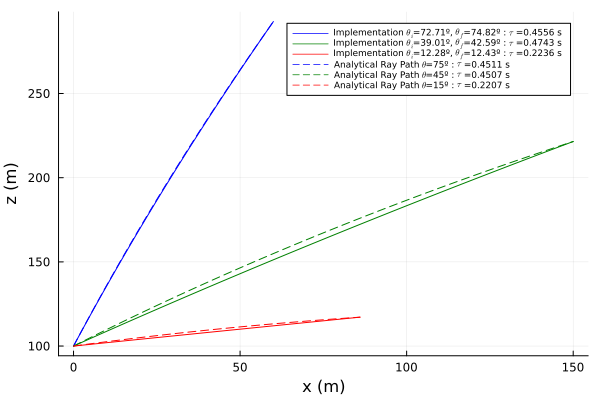

In [8]:
using Plots
p=plot(legend=:topright, legendfontsize=6)

# Own implementation
plot!(P1_ImPropia[:,1],P1_ImPropia[:,2],label="Implementation \$\\theta_i\$=72.71º, \$\\theta_f\$=74.82º : \$\\tau\$ =0.4556 s ", color=:blue)
plot!(P2_ImPropia[:,1],P2_ImPropia[:,2],label="Implementation \$\\theta_i\$=39.01º, \$\\theta_f\$=42.59º : \$\\tau\$ =0.4743 s ", color=:green)
plot!(P3_ImPropia[:,1],P3_ImPropia[:,2],label="Implementation \$\\theta_i\$=12.28º, \$\\theta_f\$=12.43º : \$\\tau\$ =0.2236 s ", color=:red)
#Analytical
plot!(x1_coords,z1_coords, label="Analytical Ray Path \$\\theta\$=75º : \$\\tau\$ =0.4511 s ", color=:blue, style=:dash)
plot!(x2_coords,z2_coords, label="Analytical Ray Path \$\\theta\$=45º : \$\\tau\$ =0.4507 s ", color=:green, style=:dash)
plot!(x3_coords,z3_coords, label="Analytical Ray Path \$\\theta\$=15º : \$\\tau\$ =0.2207 s ", color=:red, style=:dash)


# Add labels to the axes
xlabel!("x (m)")
ylabel!("z (m)")

# Save the figure
#savefig(p, "name.png")